# Data Science Group Project Report 006-021
*An analysis on the Heart Disease Hungarian Data*
##### Members: 
- Jaden Lai (79465795)
- Percy Pham (70210562)
- Sydney Trim (86059649)

### Introduction:
Heart disease is a leading cause of death worldwide and is associated with various variables. The aim of this project is to identify patients who have, or are likely to develop, heart disease by analyzing age, resting blood pressure, maximum heart rate, and cholesterol levels. To answer this question, we will analyze the Heart Disease Data Set from the Hungarian Institute of Cardiology. Although this dataset provides fourteen attributes, we have selected four of them to find an answer to our question. We chose these variables based on references from scientific articles, and because we were limited to using exclusively numerical variables as categorical values such as sex interfered with the forward selection process. Maximum heart rate, cholesterol, age, and resting blood pressure have been linked to heart disease through peer-reviewed scientific articles. These papers claim that the maximum heart rate and age of a patient increase the risk of heart diseases, that resting blood pressure is positively associated with an increased risk, and lastly, that cholesterol concentrations are connected to coronary heart disease.

##### Question: 
How can age, resting blood pressure, maximum heart rate, and cholesterol be used to identify the patients who are at the highest risk of experiencing heart disease?

In [60]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

### Methods & Results

We begin by downloading, cleaning, and wrangling the data set where we assign column names, select our variables of interest, and filter missing cells; all the pre-processing needed to analyze this heart data set.

In [61]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", "project.csv")
heart_disease_hungarian <- read_csv("project.csv", col_names = FALSE)
colnames(heart_disease_hungarian) <- c("age", "sex", "chest_pain", "resting_blood_pressure", "cholesterol",
                                       "fasting_blood_sugar", "resting_electrocardiographic_results", "maximum_heart_rate_achieved", 
                                       "exercise_induced_angina", "ST_depression",
                                       "slope_of_peak_exercise_ST_segment",
                                       "number_of_major_vessels", "thalassemia", "heart_disease_cases")

heart_disease_hungarian <- heart_disease_hungarian |>
             select(age, resting_blood_pressure, maximum_heart_rate_achieved,  cholesterol, heart_disease_cases) |>
             mutate(maximum_heart_rate_achieved = as.numeric(maximum_heart_rate_achieved)) |>
             mutate(cholesterol = as.numeric(cholesterol)) |>
             mutate(resting_blood_pressure = as.numeric(resting_blood_pressure)) |>
             mutate(heart_disease_cases = as.factor(heart_disease_cases)) |>
             filter(maximum_heart_rate_achieved != "NA") |>
             filter(resting_blood_pressure != "NA") |>
             filter(age != "NA") |>
             filter(resting_blood_pressure != "NA") |>
             filter(cholesterol != "?")

heart_disease_hungarian

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,resting_blood_pressure,maximum_heart_rate_achieved,cholesterol,heart_disease_cases
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,130,185,132,0
29,120,160,243,0
30,170,170,237,0
⋮,⋮,⋮,⋮,⋮
56,155,150,342,1
58,180,110,393,1
65,130,115,275,1


*Table 1: Cleaned heart disease data set*

##### Variable Explanation:
- Resting blood pressure: mmHg
- Cholesterol: mg/dl
- Heat disease cases: 1 = Positive, 0 = Negative

Now that we have cleaned our dataset, we perform a summary in preparation for exploratory data analysis.

In [66]:
 heart_disease_hungarian_summarize <- heart_disease_hungarian |> 
            filter(heart_disease_cases == 1) |>
            group_by(age) |>
            summarize(case_count = n()) |>
            arrange(case_count)

heart_disease_hungarian_summarize

age,case_count
<dbl>,<int>
31,1
32,1
33,1
⋮,⋮
48,8
52,8
54,8


*Table 2: Number of cases per year of age in the data set in descending order*

In [67]:
tail(heart_disease_hungarian_summarize, 6)

age,case_count
<dbl>,<int>
58,5
46,6
49,7
48,8
52,8
54,8


*Table 3: Top six years of age with most heart disease cases*

##### Table Summary:
Organizing our data set, we can make an inference that heart disease cases are mostly found in older patients in the age range of 45-55,testing positive most frequently at the age of 54, and as early as 31.

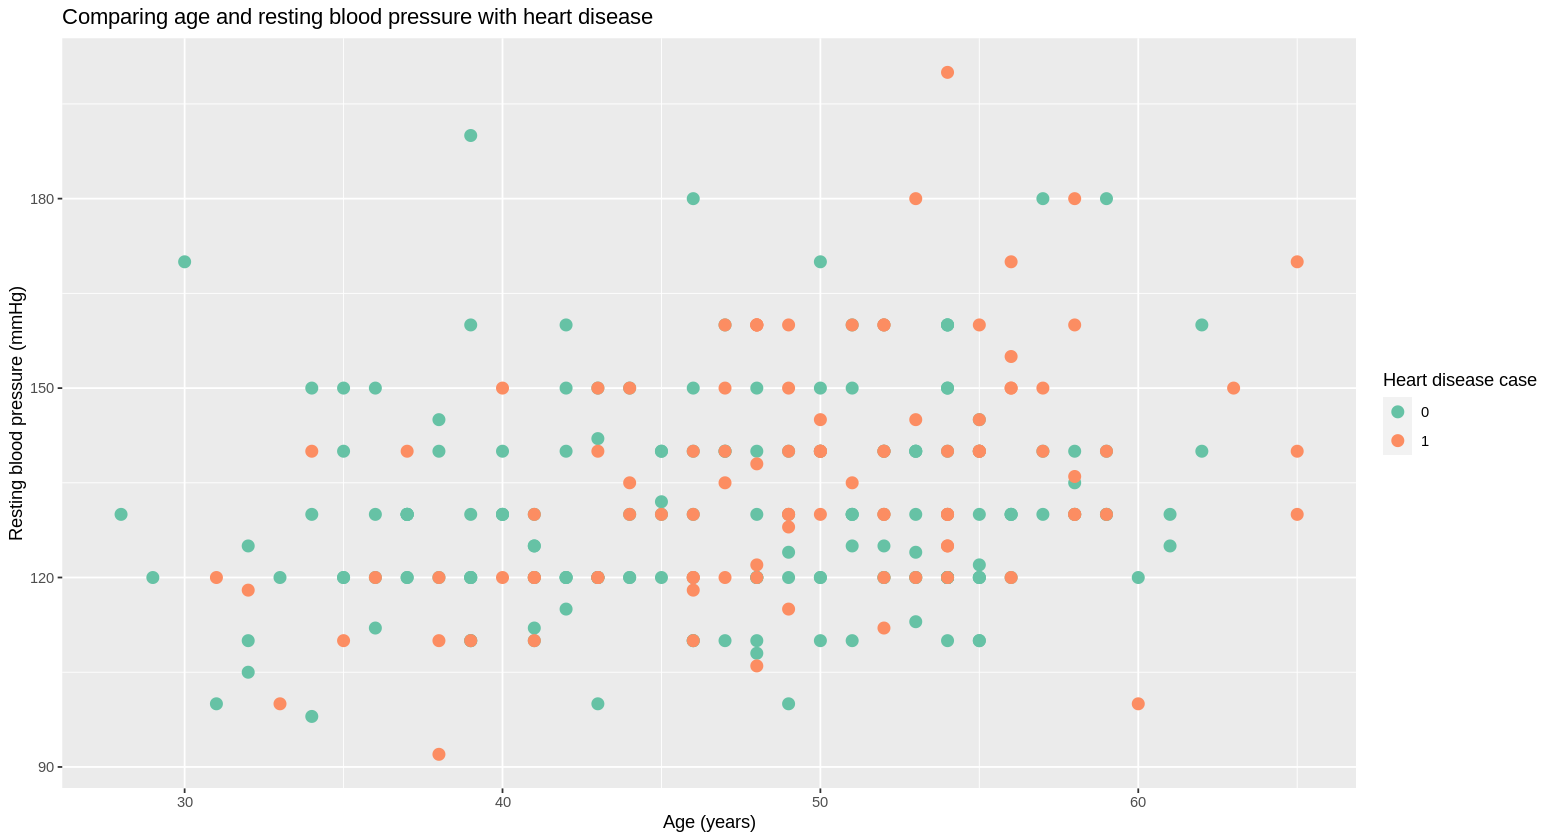

In [68]:
options(repr.plot.width = 13, repr.plot.height = 7)

heart_disease_plot <- heart_disease_hungarian |> 
    ggplot(aes(x = age, y = resting_blood_pressure, color = heart_disease_cases)) + 
        geom_point(size = 3) +
        labs(x = "Age (years)", y = "Resting blood pressure (mmHg)", color = "Heart disease case", title = "Comparing age and resting blood pressure with heart disease") +
        scale_color_brewer(palette = "Set2")

heart_disease_plot

*Plot 1: Plotting age vs resting blood pressure*

##### Explanation of Data Graph:
From reading the graph there seems to be no real relationship between the variables blood pressure and heart disease. Patients diagnosed with heart disease are predominantly found within the age range of 45-60 hence, we can establish the connection between age and heart disease cases.

##### Forward Selection:
We begin our analysis by finding the most accurate model and best predictors for heart disease, hence, our reason for performing the forward selection process. We first extract the column names, and then create an empty tibble to store the results.

In [69]:
names <- colnames(heart_disease_hungarian |> select(-heart_disease_cases))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

Next, we create our model specification and perform our 5-fold cross-validation. To perform forward selection, we also must store the number of predictors, and store the selected predictors.

In [70]:
set.seed(27)
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

heart_disease_vfold <- vfold_cv(heart_disease_hungarian, v = 5, strata = heart_disease_cases)

n_total <- length(names)

selected <- c()

The following code is taken directly from the textbook as forward selection goes beyond our knowledge in DSCI100

In [71]:
set.seed(27)
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("heart_disease_cases", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_disease_recipe <- recipe(as.formula(model_string), 
                                data = heart_disease_hungarian) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_disease_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_disease_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,heart_disease_cases ~ maximum_heart_rate_achieved,0.6673045
2,heart_disease_cases ~ maximum_heart_rate_achieved+cholesterol,0.6819147
3,heart_disease_cases ~ maximum_heart_rate_achieved+cholesterol+age,0.6816378
4,heart_disease_cases ~ maximum_heart_rate_achieved+cholesterol+age+resting_blood_pressure,0.6778769


*Table 4: Accuracy estimates produced using forward selection*

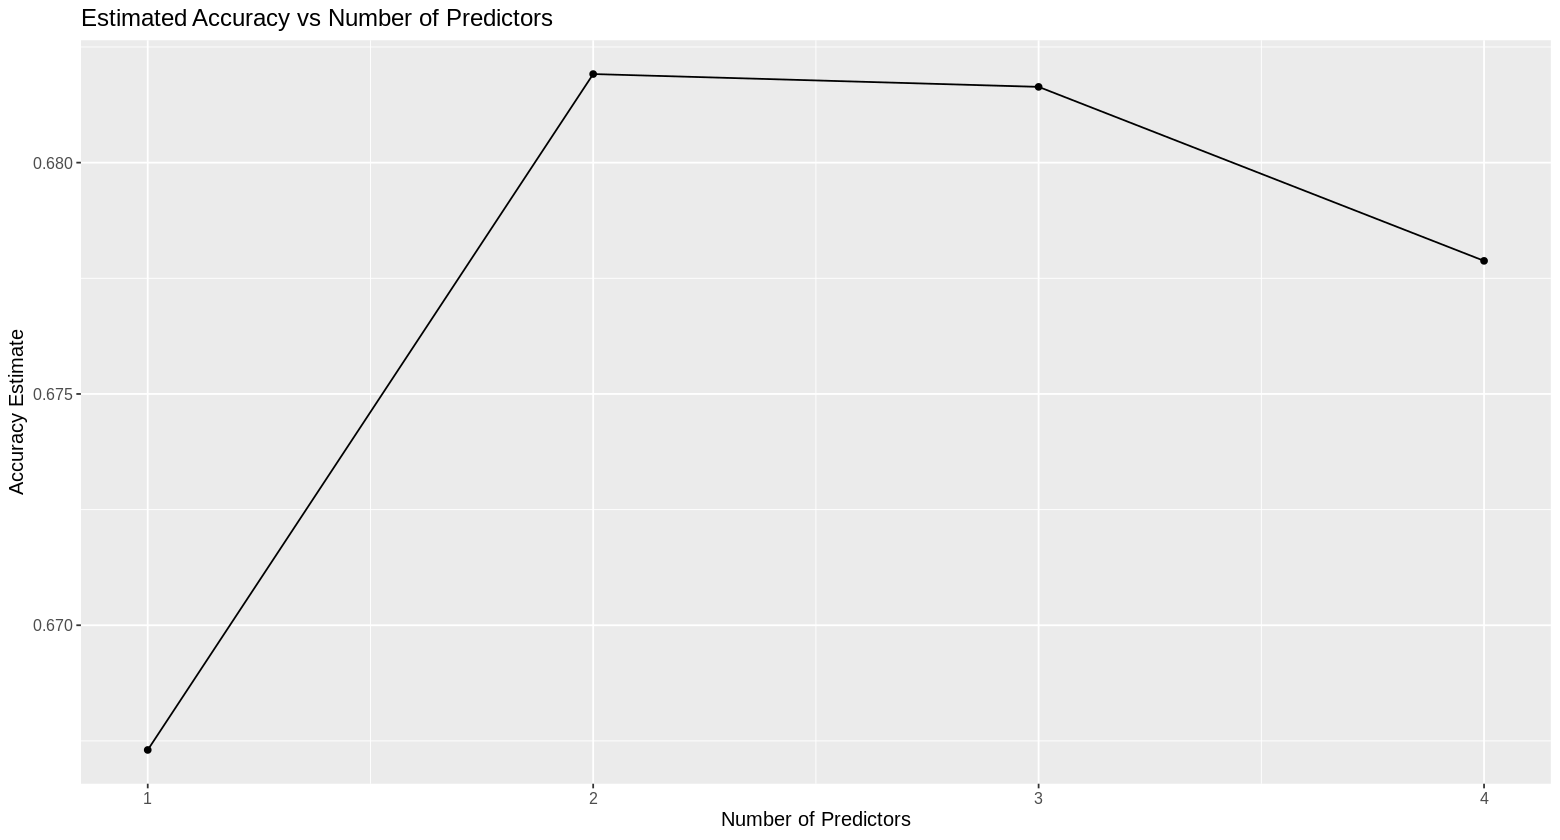

In [72]:
accuracy_vs_k <- ggplot(accuracies, aes(x = size, y = accuracy)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Predictors", y = "Accuracy Estimate", title = "Estimated Accuracy vs Number of Predictors") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

*Plot 2: Finding the optimal number of predictors*

Notice that the number of predictors is estimated to be the most accurate at two predictors.

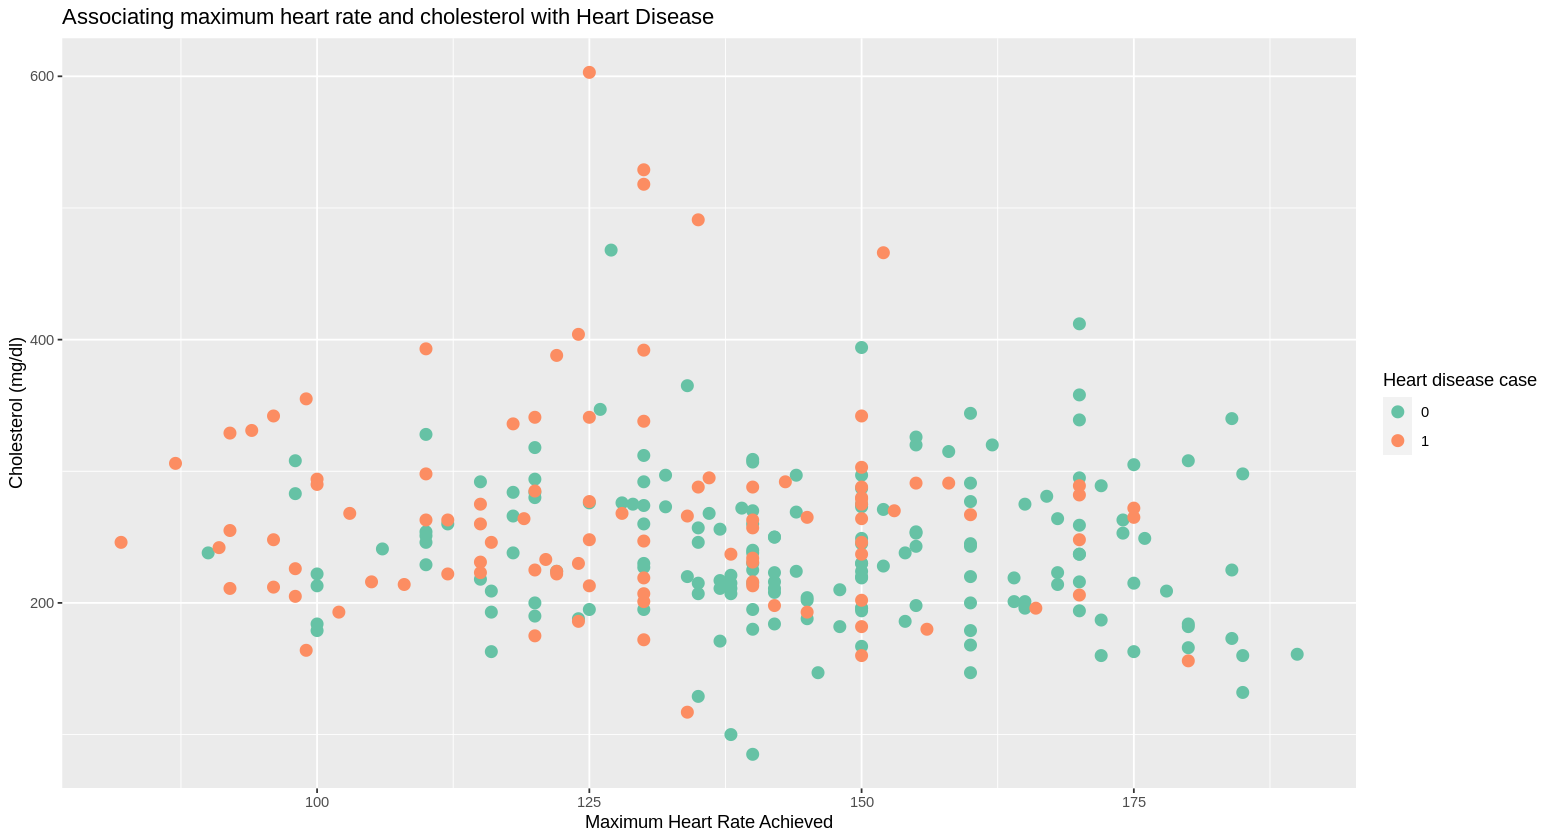

In [73]:
options(repr.plot.width = 13, repr.plot.height = 7)

heart_disease_plot_best <- heart_disease_hungarian |> 
    ggplot(aes(x = maximum_heart_rate_achieved, y = cholesterol, color = heart_disease_cases)) + 
        geom_point(size = 3) +
        labs(x = "Maximum Heart Rate Achieved", y = "Cholesterol (mg/dl)", color = "Heart disease case", title = "Associating maximum heart rate and cholesterol with Heart Disease") +
         scale_color_brewer(palette = "Set2")

heart_disease_plot_best

*Plot 3: Plotting the two highest accuracy estimate predictors*

Now that we have found the best accuracy estimate predictors to use, we will begin our cross-validation by splitting our data into a training and testing set.

In [74]:
set.seed(27)
hd_keep <- select(heart_disease_hungarian, maximum_heart_rate_achieved, cholesterol,heart_disease_cases)

hd_split <- initial_split(hd_keep, prop = 0.75, strata = heart_disease_cases)
hd_train <- training(hd_split)   
hd_test <- testing(hd_split)

We use vfold to split the training data for cross validation and a recipe that specifies our target and predictor variables with scaling.

In [75]:
hd_vfold <- vfold_cv(hd_train, v = 5, strata = heart_disease_cases)

hd_recipe <- recipe(heart_disease_cases ~ maximum_heart_rate_achieved + cholesterol, data = hd_train) |>
              step_scale(all_predictors()) |>
              step_center(all_predictors())

We now create a nearest neighbors workflow using our previously created recipe and model to estimate our classifiers accuacy for selected K values.

In [89]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

knn_results <- workflow() |>
                 add_recipe(hd_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = hd_vfold, grid = tibble(neighbors = c(2,3,4,5,6,7,8,9,10))) |>
                 collect_metrics() |>
                 filter(.metric == 'accuracy')

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6164634,5,0.02577473,Preprocessor1_Model1
3,accuracy,binary,0.6663415,5,0.01815333,Preprocessor1_Model2
4,accuracy,binary,0.6663415,5,0.01815333,Preprocessor1_Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.6913415,5,0.02372288,Preprocessor1_Model7
9,accuracy,binary,0.6712195,5,0.03464488,Preprocessor1_Model8
10,accuracy,binary,0.6712195,5,0.03464488,Preprocessor1_Model9


*Table 5: Workflow with recipe and model to find accuarcy estimates using different K values*

Next, we plot our k values against their estimated accuracies in order to choose the most optimal k value.

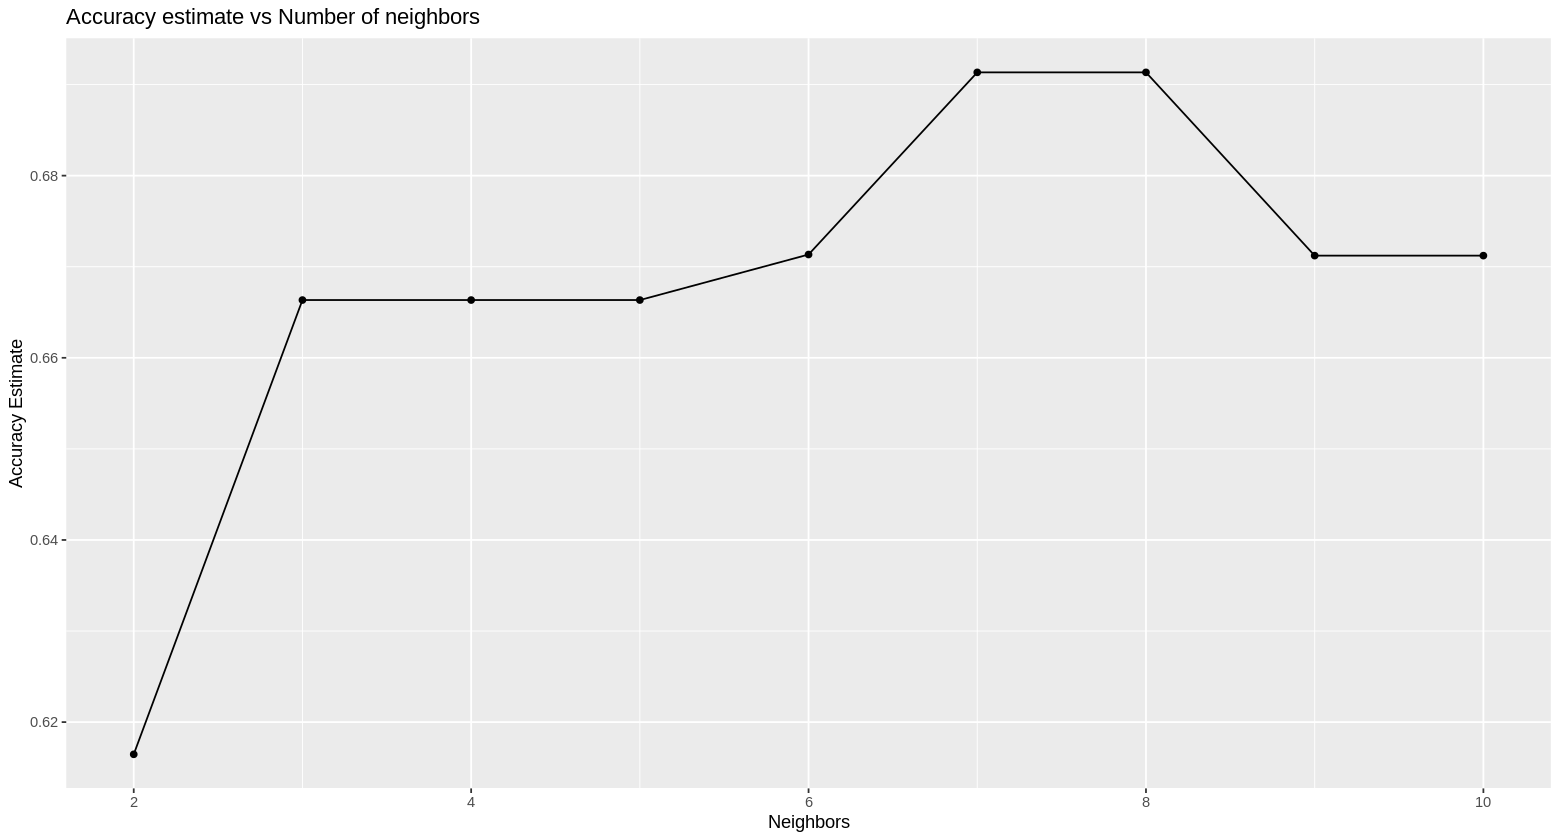

In [90]:
cross_val_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate', title = "Accuracy estimate vs Number of neighbors")

cross_val_plot

It appears the most optimal k value is k = 8. We also verify this by taking the results and sorting by mean. Now we can create a new model specification with the best K value and re-train the classifier using fit(). After we have created our new model, we can evaluate the estimated accuracy of the new classifier on the test set using predict().

In [91]:
knn_results <- knn_results |>
                arrange(mean) |>
                tail(1) |>
                select(neighbors)

knn_results

neighbors
<dbl>
8


*Plot 4: Plotting neighbors vs accuracy estimate*

In [92]:
hd_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
       set_engine("kknn") |>
       set_mode("classification")

hd_fit <- workflow() |>
       add_recipe(hd_recipe) |>
       add_model(hd_spec) |>
       fit(data = hd_train)

hd_predictions <- predict(hd_fit , hd_test) |>
       bind_cols(hd_test)

hd_acc <- hd_predictions |> 
    metrics(truth = heart_disease_cases, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

hd_acc

.metric,.estimate
<chr>,<dbl>
accuracy,0.6231884


*Table 6: Classification accuracy*

In [93]:
hd_cm <- hd_predictions |> 
    conf_mat(truth = heart_disease_cases, estimate = .pred_class)

hd_cm

          Truth
Prediction  0  1
         0 33 16
         1 10 10

*Table 7: Confusion matrix*

Our model using the highest estimated accuracy predictors, and the highest estimated accuracy K value, yielded an accuracy estimate of 62%. In our confusion matrix, notice that 33 cases were predicted correctly as negative, while 10 were predicted correctly as positive for heart disease. 16 + 10 = 26 classifications however, were incorrectly predicted. Now, we will create a visualization from our classification results showing our correct predictions, and incorrect predictions. We can do this by creating a new column where .pred_class and herat_disease_cases are not equal, meaning the predicted class is different from the actual class. We can then visualize this by assigning color to the prediction result to see which observations were correctly or incorrectly classified

In [94]:
incorrect_observations <- hd_predictions |> 
                    mutate(prediction_result = .pred_class != heart_disease_cases)

incorrect_observations

.pred_class,maximum_heart_rate_achieved,cholesterol,heart_disease_cases,prediction_result
<fct>,<dbl>,<dbl>,<fct>,<lgl>
0,185,132,0,FALSE
0,184,225,0,FALSE
0,155,254,0,FALSE
⋮,⋮,⋮,⋮,⋮
1,122,388,1,FALSE
0,135,288,1,TRUE
0,158,291,1,TRUE


*Table 8: Classification results with prediction results column*

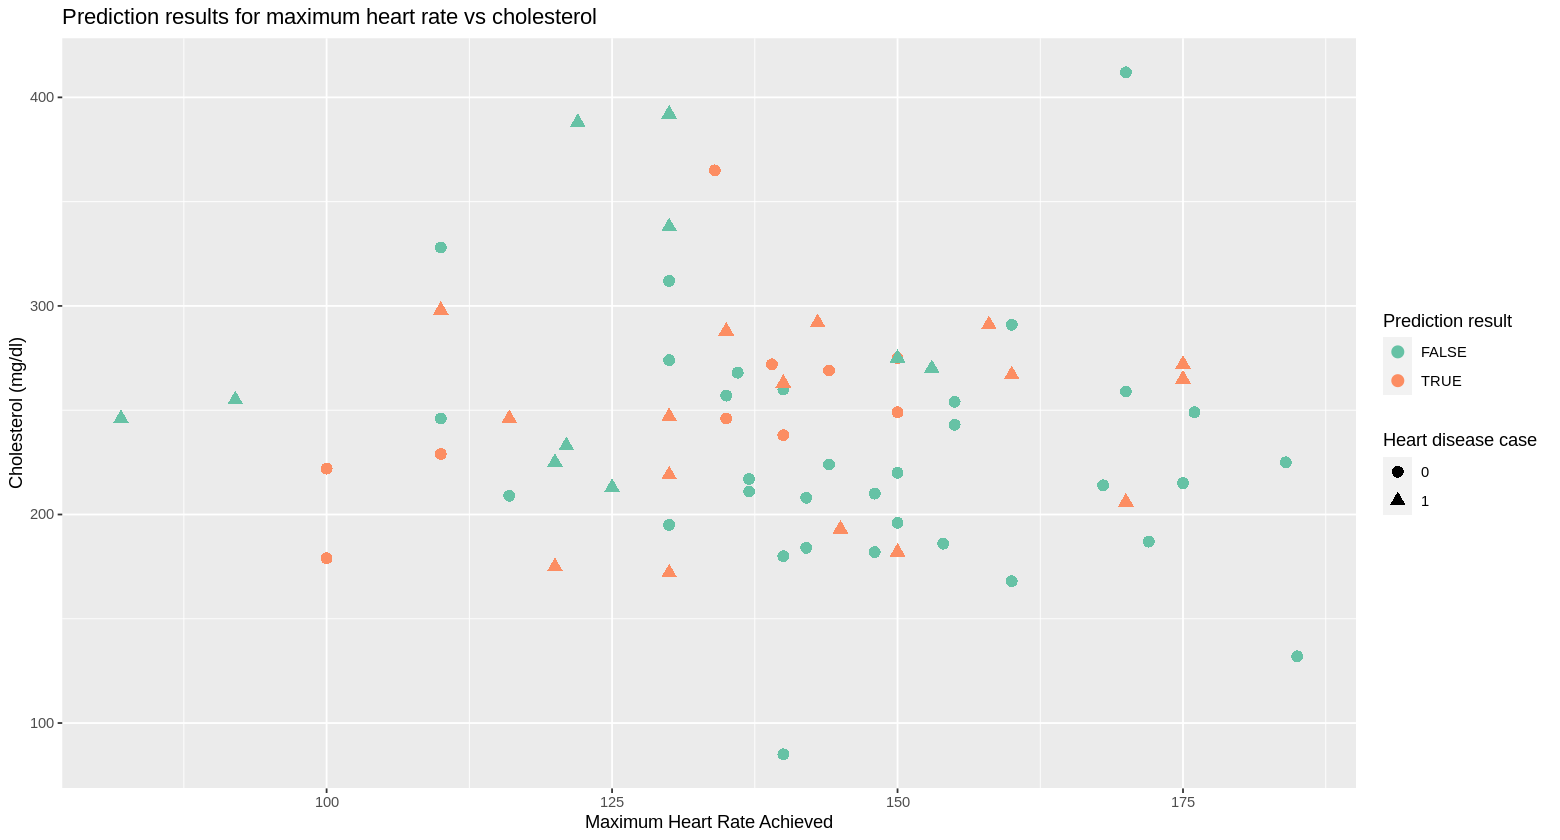

In [95]:
heart_disease_prediction_result_plot <- incorrect_observations |> 
    ggplot(aes(x = maximum_heart_rate_achieved, y = cholesterol, shape = heart_disease_cases, color = prediction_result)) + 
        geom_point(size = 3) +
        labs(x = "Maximum Heart Rate Achieved", y = "Cholesterol (mg/dl)", shape = "Heart disease case", color = "Prediction result", title = "Prediction results for maximum heart rate vs cholesterol") +
        scale_color_brewer(palette = "Set2")

heart_disease_prediction_result_plot

*Plot 5: Visualizing correct and incorrect observations from prediction results*

### Discussion:
##### What did we find?
Based on our findings in the forward selection model, we identified the most accurate predictors for patients with heart disease as cholesterol and maximum heart rate, as shown in Plot 2 and Table 4. When these predictors were combined, the estimated accuracy was 68.19%. The other predictor values also showed high accuracies, with 68.16% for maximum heart rate, cholesterol, and age; 67.78% for maximum heart rate, cholesterol, age, and resting blood pressure; and the least accurate value being 66.73% for just maximum heart rate. However, when we compared our forward selection model to our final classification model, we observed a decrease in accuracy of nearly 5%, as seen in Table 4 and Table 6. These results could have been skewed based on the sheer size of the dataset, the patient distribution, and our restriction to using numerical variables only. In a real-world setting, our classifier may not be accurate enough to consistently identify patients at risk and those who are not. Nevertheless, our findings could prompt discussions with patients who have elevated levels of cholesterol and maximum heart rate and encourage them to undergo further testing.
##### Is this what we expected?
We anticipated finding strong associations between age and heart disease; however, this was not what we discovered. Instead, we observed that higher levels of cholesterol and maximum heart rate were strong predictors of heart disease. Surprisingly, age did not prove to be a predictor that accurately helped us predict whether someone had heart disease. Plot 1 revealed that older patients between the ages of 45 to 55 were the most common subjects to have heart disease, with some patients as young as 31 also testing positive. We also expected the accuracy of our model to remain relatively constant across all models, but we observed a decrease in accuracy from 68.19% to 62%, which is significant in both medical and analytical contexts, despite still remaining within the 60-70% range.
##### What impacts do these findings have?
Our findings can contribute to identifying patients who could benefit from further testing based on their cholesterol or maximum heart rate levels. However, our results also show that the variables we tested, including age, maximum heart rate, cholesterol, and resting blood pressure, have a weak relationship with heart disease and are not sufficient to identify patients at risk with high accuracy. The accuracies found in the analysis of this dataset are clearly not high enough to be used definitively, with its classification result being similar to the roll of a dice. This report in that sense, acts moreso, as a conversation starter more than anything. However, this research adds to the existing medical knowledge and advocates for prevention of this cardiovascular disease.
##### What future questions does this lead to?
Our findings raise several questions, such as: What other variables, besides cholesterol and maximum heart rate achieved, could predispose people to heart disease? How can we improve access to these tests for those at higher risk? What are the optimal levels of cholesterol and maximum heart rate that predisposed patients should aim to achieve? How can people use this new information to prevent heart disease?
### References:
- He, K., Chen, X., Shi, Z., Shi, S., Tian, Q., Hu, X., Song, R., Bai, K., Shi, W., Wang, J., Li, H., Ding, J., Geng, S., & Sheng, X. (2022). Relationship of resting heart rate and blood pressure with all-cause and cardiovascular disease mortality. Public Health, 208, 80–88. https://doi.org/10.1016/j.puhe.2022.03.020 
- Moran, A. E., Tzong, K. Y., Forouzanfar, M. H., Roth, G. A., Mensah, G. A., Ezzati, M., Murray, C. J. L., & Naghavi, M. (2014). Variations in ischemic heart disease burden by age, country, and income: the global burden of diseases, injuries, and risk factors 2010 study. Global Heart, 9(1), 91. https://doi.org/10.1016/j.gheart.2013.12.007 
- Park, C., Guallar, E., Linton, J. A., Lee, D.-C., Jang, Y., Son, D. K., Han, E.-J., Baek, S. J., Yun, Y. D., Jee, S. H., & Samet, J. M. (2013). Fasting glucose level and the risk of incident atherosclerotic cardiovascular diseases. Diabetes Care, 36(7), 1988–1993. https://doi.org/10.2337/dc12-1577 
- Liou L, Kaptoge S (2020) Association of small, dense LDL-cholesterol concentration and lipoprotein particle characteristics with coronary heart disease: A systematic review and meta-analysis. PLoS ONE 15(11): e0241993. https://doi.org/10.1371/journal.pone.0241993
- Han SH, Choi MS, Kim YM, Kim DM, Park HE, Hong JW, Kim SH, Shin YB, Lee BJ. Is Age-Predicted Maximal Heart Rate Applicable in Patients With Heart or Lung Disease? Ann Rehabil Med. 2022 Jun;46(3):133-141. doi: 10.5535/arm.21181. Epub 2022 Jun 30. PMID: 35793902; PMCID: PMC9263326. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9263326/